In [28]:
#
# Import all the dependencies
#
import os
import keras
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras import layers, Input, Model
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.layers import (GRU, Dense, Lambda, Masking, RepeatVector, TimeDistributed, concatenate)

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
tf.config.run_functions_eagerly(True)

In [31]:
#
# Create '/latent_space_data/' folder if it does not exist already
#
if not os.path.exists('/content/gdrive/My Drive/latent_space_data'):
    os.makedirs('/content/gdrive/My Drive/latent_space_data')
#
# Create '/latent_space_data/vae/' folder
# to store the VAE data
#
if not os.path.exists('/content/gdrive/My Drive/latent_space_data/vae/'):
    os.makedirs('/content/gdrive/My Drive/latent_space_data/vae/')
#
# Create '/latent_space_data/vae/decoded_plots' folder
# to save the decoded light curves
#
if not os.path.exists('/content/gdrive/My Drive/latent_space_data/vae/decoded_plots'):
    os.makedirs('/content/gdrive/My Drive/latent_space_data/vae/decoded_plots')


In [32]:
class CustomMasking(layers.Layer):
    def __init__(self, **kwargs):
        super(CustomMasking, self).__init__(name="CustomMasking", **kwargs)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        return inputs * mask


In [33]:
class Sampling(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(Sampling, self).__init__(name="Sampling", **kwargs)
        self.output_dim = output_dim
        self.supports_masking = True

    def call(self, inputs, mask=None):
        # print("Sampling Output:", inputs)
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon

        return output

In [34]:
class Encoder(keras.Model):
    def __init__(self, shapes, mask_val=0, name='encoder', **kwargs):
        # properties
        self.mask_val = mask_val
        self.shapes = shapes

        # call Model initializer
        super(Encoder, self).__init__(name=name, **kwargs)

        # define Encoder layers
        self.mask = Masking(mask_value=mask_val)

        # first recurrent layer
        self.gru1 = GRU(shapes['gru1'],
                        activation='tanh',
                        recurrent_activation='hard_sigmoid',
                        return_sequences=True,
                        name='gru1')
        # second recurrent layer
        self.encoded = GRU(
            shapes['gru2'],
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            return_sequences=True,
            name='gru2')

        # z mean output
        self.z_mean = GRU(
            shapes['gru3'],
            return_sequences=False,
            activation='linear',
            name='gru3')

        # z variance output
        self.z_log_var = GRU(
            shapes['gru4'],
            return_sequences=False,
            activation='linear',
            name='gru4'
        )

        # sample output
        self.z = Sampling(shapes['gru4'])

    def get_config(self):
        return {"shapes": self.shapes, 'mask_val': 0, 'name': 'encoder'}

    # define forward pass
    def call(self, inputs):
        mask_tensor = self.mask(inputs)
        gru1 = self.gru1(mask_tensor)
        encoded = self.encoded(gru1)
        z_mean = self.z_mean(encoded)
        z_log_var = self.z_log_var(encoded)
        z = self.z([z_mean, z_log_var])

        return z_mean, z_log_var, z


In [35]:
class Decoder(keras.Model):
    def __init__(self, shapes, mask_val=0, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.mask_val = mask_val
        self.shapes = shapes

        # define layers
        self.repeater = RepeatVector(shapes['repeater'], name='rep')

        self.custom_mask = CustomMasking()

        # first recurrent layer
        self.gru5 = GRU(
            shapes['gru5'],
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            return_sequences=True,
            name='gru5')

        # second recurrent layer
        self.gru6 = GRU(
            shapes['gru6'],
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            return_sequences=True,
            name='gru6')

        # decoder output
        self.dec_output = TimeDistributed(
            Dense(1, activation='tanh', input_shape=shapes['dec_output']),
            name='td')

    def get_config(self):
        config = {
            "shapes": self.shapes,
            'mask_val': 0,
            'name': 'decoder'}
        return config

    # define forward pass
    def call(self, inputs):
        z, train_input_two, masks, dec_masks = inputs
        # back at 200 numbs
        repeater = self.repeater(z)

        concat = concatenate([repeater, train_input_two], axis=-1)

        mask_tensor = self.custom_mask(concat, mask=masks)

        gru5 = self.gru5(mask_tensor, mask=None)

        gru6 = self.gru6(gru5)

        dec_output = self.dec_output(gru6)

        return self.custom_mask(dec_output, mask=dec_masks)
        #return dec_output


In [36]:
class VAE(keras.Model):
    def __init__(self, prepared_data, name='vae', **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.epochs = 10
        self.batch_size = 100
        self.optimizer = 'adam'
        dims = np.asarray(prepared_data).shape

        # dimension of the latent vector
        self.latent_dim = 5

        # input to first encoder and second decoder layer
        self.gru_one = 175

        # input to first decoder and second encoder layer
        self.gru_two = 150

        # load prepared dad (acts a input)
        self.prepared_data = np.array(prepared_data)

        # number of input features
        self.num_feats = dims[2]

        # number of timesteps
        self.num_timesteps = dims[1]

        # dimension of the input space for encoder
        self.enc_input_shape = (self.num_timesteps, self.num_feats)

        # number of light curves
        self.num_lcs = dims[0]

        # layer dimensions for encoder and decoder, respectively
        self.enc_dims = {
            'enc_input': self.enc_input_shape,
            'gru1': self.gru_one,
            'gru2': self.gru_two,
            'gru3': self.latent_dim,
            'gru4': self.latent_dim
        }
        self.dec_dims = {
            'dec_input': self.latent_dim,
            'repeater': self.num_timesteps,
            'input_two': (self.num_timesteps, 2),
            'gru5': self.gru_two,
            'gru6': self.gru_one,
            'dec_output': (None, 1)
        }

        # indxs for test and train
        self.train_indx = set()
        self.test_indx = set()

        self.mask_value = 0.0

        self.encoder = Encoder(self.enc_dims)
        self.decoder = Decoder(self.dec_dims)

    def get_config(self):
        config = {"prepared_data": np.array(self.prepared_data), 'name': 'vae'}
        return config

    # define forward pass
    def call(self, inputs):
        x_train, train_input_two, masks, dec_masks = inputs
        z_mean, z_log_var, z = self.encoder(x_train)
        reconstructed = self.decoder([z, train_input_two, masks, dec_masks])

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def reconstruction_loss(self, yTrue, yPred):
        return K.log(K.mean(K.square(yTrue - yPred)))

    def split_training_data(self):
        """
        Splits data into 3/4 training, 1/4 testing
        """

        print("Splitting data into train and test...")

        # prepared out (only flux)
        prep_out = self.prepared_data[:, :, 2].reshape(self.num_lcs, self.num_timesteps, 1)
        prep_inp = self.prepared_data

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        
        """
        Comments: if len(num_lcs)=100 then the code below assumes - train_perc = 100 and test_perc = 20. 
                  It's not a 3/4 training, 1/4 testing
        """

        # calc the # of light curves for train vs test
        num_lcs = len(prep_inp)
        train_perc = round(1.0 * num_lcs)
        test_perc = round(num_lcs * 0.2)

        """
        Comments: both the lists self.train_indx and self.test_index can hold the same 
                  indices for lcs as the condition is missing. 
        """

        # save random indices for training
        while len(self.train_indx) != train_perc:
            indx = random.randint(0, num_lcs - 1)
            self.train_indx.add(indx)

        # save random indices for testint -> no duplicates from training
        while len(self.test_indx) <= test_perc:
            indx = random.randint(0, num_lcs - 1)
            # if indx not in self.train_indx:
            self.test_indx.add(indx)

        # extract training data
        for ind in self.train_indx:
            x_train.append(prep_inp[ind])
            y_train.append(prep_out[ind])

        # extract testing data
        for ind in self.test_indx:
            x_test.append(prep_inp[ind])
            y_test.append(prep_out[ind])

        # change to numpy arrays
        x_train = np.array(x_train).astype(np.float64)
        x_test = np.array(x_test).astype(np.float64)
        y_train = np.array(y_train).astype(np.float64)
        y_test = np.array(y_test).astype(np.float64)

        print('shape of prep_inp and x_train:', prep_inp.shape, x_train.shape)
        print('shape of prep_out and y_train:', prep_out.shape, y_train.shape)
        print('shape of prep_inp and x_test:', prep_inp.shape, x_test.shape)
        print('shape of prep_out and y_test:', prep_out.shape, y_test.shape)

        return x_train, x_test, y_train, y_test, prep_inp, prep_out

    def compute_masks(self, x_train, size):
      """
      This is hard-coded. If there is any meta-data added to the lcs such as - (time, band, flux, error, redshift and/or mwebv)
      then the for loop condition needs to change

      for (time, band, flux, error) in light_curve:

      """
      masks = []
      for light_curves in x_train:
          mask = []
          for lc in light_curves:
              if lc[1] == 0:
                  mask.append([0.0] * (size))
              else:
                  mask.append([1.0] * (size))
          masks.append(mask)

      return np.array(masks)

    
    def train_model(self, x_train, x_test, y_train, y_test):
        """
        Trains the NN on training data

        Returns the trained model.
        """
        # fit model
        train_inp_two = x_train[:, :, :2]
        assert (train_inp_two.shape == (x_train.shape[0], x_train.shape[1], 2))

        test_inp_two = x_test[:, :, :2]
        assert (test_inp_two.shape == (x_test.shape[0], x_test.shape[1], 2))

        train_masks = self.compute_masks(x_train, self.latent_dim + 2)
        test_masks = self.compute_masks(x_test, self.latent_dim + 2)

        train_dec_output_masks = self.compute_masks(x_train, 1)
        test_dec_output_masks = self.compute_masks(x_test, 1)

        print('fitting model...')
        history = self.fit([x_train, train_inp_two, train_masks, train_dec_output_masks],
                           y_train, epochs=self.epochs, batch_size=self.batch_size,
                           validation_data=([x_test, test_inp_two, test_masks, test_dec_output_masks], y_test),
                           verbose=1, shuffle=False)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def test_model(self, x_test, y_test, amount=None):
        """
        Uses test data to and NN to predict light curve decodings.

        Plots reconstructed light curved from the model prediction vs the orignal curve.
        """
        if amount:
            indices = random.sample(range(len(x_test)), k=amount)
            x_test = np.array([x_test[i] for i in indices])
            y_test = np.array([y_test[i] for i in indices])

        test_inp_two = x_test[:, :, :2]

        self.summary()
        #
        # Create array to store the encoded flux
        #
        # encoded_flux = np.zeros((len(x_test), len(x_test[0])))

        # print(f"\nencoded_flux: {encoded_flux.shape}")
    
        print('predicting...')


        for i in tqdm(range(len(x_test))):

            # predicted flux
            predicted = self.predict([x_test[i].reshape(-1, self.num_timesteps, x_test.shape[2]),
                                      test_inp_two[i].reshape(-1, self.num_timesteps, 2),
                                      # train_masks
                                      self.compute_masks(x_test[i].reshape(-1, self.num_timesteps, x_test.shape[2]),
                                                         self.latent_dim + 2),
                                      # train output masks
                                      self.compute_masks(x_test[i].reshape(-1, self.num_timesteps, x_test.shape[2]), 1)
                                      ])[0]
            
            # if first prediction, print the prediction
            if i == 0:
                print('shape of predicted data: ', predicted.shape)

            self.plot_band_pred(y_test[i], predicted, i, test_inp_two[i])

        print("done predicting")
        

    def plot_band_pred(self, raw, pred, num, time_filters):
        
        raw_g_flux = []
        raw_r_flux = []
        raw_tess_flux = []

        pred_g_flux = []
        pred_r_flux = []
        pred_tess_flux = []

        g_time = []
        r_time = []
        tess_time = []
        
        for i in range(len(time_filters)):
            time, filter_ID = time_filters[i]
            raw_flux = raw[i, 0]
            pred_flux = pred[i, 0]
            if filter_ID == 4.716:
                raw_g_flux.append(raw_flux)
                pred_g_flux.append(pred_flux)
                g_time.append(time)
            elif filter_ID == 6.215:
                raw_r_flux.append(raw_flux)
                pred_r_flux.append(pred_flux)
                r_time.append(time)
            

        # plot
        # make 1 x 2 figure
        fig, (ax1, ax2) = plt.subplots(2, sharey=True)
        fig.suptitle('True vs Decoded Light Curves: ')  # + str(light_curve_names[num]))

        # plot raw data
        ax1.scatter(g_time, raw_g_flux, label='g-band', color='green')
        ax1.scatter(r_time, raw_r_flux, label='r-band', color='red')
        ax1.scatter(tess_time, raw_tess_flux, label='tess-band')
        ax1.set_ylabel('actual')

        # plot predicted data
        ax2.set_ylabel('predicted')
        ax2.scatter(g_time, pred_g_flux, label='g-band', color='green')
        ax2.scatter(r_time, pred_r_flux, label='r-band', color='red')
        ax2.scatter(tess_time, pred_tess_flux, label='tess-band')
        # save image
        #fig.show()
        fig.savefig("/content/gdrive/My Drive/latent_space_data/vae/decoded_plots/" + str(num) + ".png")

    def save_latent_space(self, data):

        try:
          encoded_data = tf.convert_to_tensor(vae.encoder(data["x_train"]))
          encoded_data = encoded_data.numpy()
          with open(f"/content/gdrive/My Drive/latent_space_data/vae/vae_enc_data.pickle", 'wb') as file:
              pickle.dump(encoded_data[2,:,:], file)
          
          print(f"\nVAE encoded data is stored under -- /latent_space_data/vae/ folder!\n")
        except Exception as e:
          print(f"\nUnknown Error: {e}\n")

In [37]:
class GenerateData(object):

    def __init__(self, lc_type=None, passbands=["r","g"], path=None, metadata=None):

        """
        Generates data for Variational Auto-Encoder

        Parameters
        ----------
        lc_type: string
            type of light curves (transits or transients)

        passbands: list (default = ["r", "g"])
            filters in the PLAsTiCC dataset

        path: string
            the file location of the light curves

        metadata: list (default=None)
            metadata in addition to flux and flux error

        """
        self.path = path
        self.labels = None
        self.type = lc_type
        self.metadata = metadata
        self.passbands = passbands

        try:
            if self.type not in ["transits", "transients"]:
                raise ValueError(f"\nValueError: '{self.type}' is not a valid type!"
                                 f"\nPlease provide the type as - 'transits' or 'transients'.")

            if self.type == "transits":
                raise NotImplementedError(f"\nNotImplementedError: Please specify the -- type -- as 'transients'!\n"
                                          f"'{self.type}' is not implemented yet!\n")
        except Exception as e:
            print(e)
            exit()

        try:

            if self.metadata:
                for i in self.metadata:
                    if i not in ["max_flux", "mwebv", "redshift"]:
                        raise ValueError(f"\nValueError: '{i}' is an invalid metadata!"
                                         f"\nPlease provide parameters as - 'max_flux' for maximum flux, 'mwebv' "
                                         f"for Milky Way extinction, and 'redshift'.")
        except Exception as e:
            print(e)
            exit()

        try:

            for i in self.passbands:
                if i not in ["r", "g"]:
                    raise ValueError(f"\nValueError: '{i}' is an invalid passband!"
                                     f"\nPlease provide passbands as - 'r' for PLAsTiCC r-band, 'g' for PLAsTiCC g-band.")
        except Exception as e:
            print(e)
            exit()

    def generate_data(self):

        data = dict()
        curve_range = (-30, 70)
        label, columns = list(), list()
        filename = os.listdir(self.path)
        passbands_metadata = {"r": 6.215, "g": 4.716}
        metadata_cols = ["redshift", "mwebv", "max_flux"]
        #
        maskval, interval_val, n_bands = 0.0, 3.0, len(self.passbands)
        passband_values = {i: passbands_metadata[i] for i in self.passbands}
        timesteps = int(((curve_range[1] - curve_range[0]) / interval_val + 1) * n_bands)
        #
        if self.metadata:
            n_cols = 4 + len(self.metadata)
            cols_to_drop = list(set(metadata_cols) - set(self.metadata))
        else:
          n_cols = 4
        x_train = np.zeros(shape=(len(filename), timesteps, n_cols))
        #
        #
        #
        for i, csv in enumerate(filename):
            #
            # Object_ids  for the PLAsTiCC data set
            #
            fname = os.path.splitext(csv)
            #
            label.append(fname[0])
            df = pd.read_csv(self.path + csv)
            df.index = df["relative_time"]
            df = df.fillna(maskval)
            #
            combined_df = pd.DataFrame()
            #
            try:
                for pb, id in passband_values.items():
                    #
                    #
                    #
                    pb_df = df[["relative_time", "mwebv", "redshift"]].copy()
                    pb_df["id"] = id
                    pb_df["flux"] = df[f"{pb}_flux"]
                    pb_df["uncert"] = df[f"{pb}_uncert"]
                    pb_df[(pb_df["flux"] == maskval) & (pb_df["uncert"] == maskval)] = maskval
                    #
                    #
                    #
                    for t in np.arange(curve_range[0], curve_range[1], interval_val):
                        if t not in pb_df["relative_time"]:
                            pb_df.loc[t] = np.full(shape=len(pb_df.columns), fill_value=maskval)
                            pb_df = pb_df.sort_index()
                    pb_df["max_flux"] = np.full(shape=len(pb_df), fill_value=max(pb_df["flux"]))
                    pb_df[(pb_df["relative_time"] == maskval)] = maskval
                    combined_df = pd.concat([pb_df, combined_df])
            except Exception as e:
                print(f"\nUnknown Error: {e}\n")
            #
            #
            #
            try:
                ordered_col = ["relative_time", "id", "flux", "uncert", "redshift", "mwebv", "max_flux"]
                combined_df = combined_df[ordered_col]
                if cols_to_drop:
                  combined_df = combined_df.drop(columns=cols_to_drop)
                
                x_train[i] = combined_df.sort_index().to_numpy()
            except Exception as e:
                print(f"\nUnknown Error: {e}\n")
        #
        #
        #
        try:
            self.labels = label
            data["x_train"], data["labels"] = x_train, self.labels
            #
            # Store the file in -- '/latent_space_data/{type}/' folder
            #
            with open(f"/content/gdrive/My Drive/latent_space_data/vae/vae_data.pickle", 'wb') as file:
                pickle.dump(data, file)
            
            print(f"\nVAE data is generated and stored under -- /latent_space_data/vae/ folder!\n")

        except Exception as e:
            print(f"\nUnknown Error: {e}\n")



VAE data is generated and stored under -- /latent_space_data/vae/ folder!

Splitting data into train and test...
shape of prep_inp and x_train: (5700, 68, 6) (5700, 68, 6)
shape of prep_out and y_train: (5700, 68, 1) (5700, 68, 1)
shape of prep_inp and x_test: (5700, 68, 6) (1141, 68, 6)
shape of prep_out and y_test: (5700, 68, 1) (1141, 68, 1)


fitting model...
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


57/57 [==============================] - 328s 6s/step - loss: 15.4229 - val_loss: 15.7612
Epoch 2/3
57/57 [==============================] - 345s 6s/step - loss: 15.3907 - val_loss: 15.7570
Epoch 3/3
57/57 [==============================] - 327s 6s/step - loss: 15.3886 - val_loss: 15.7561


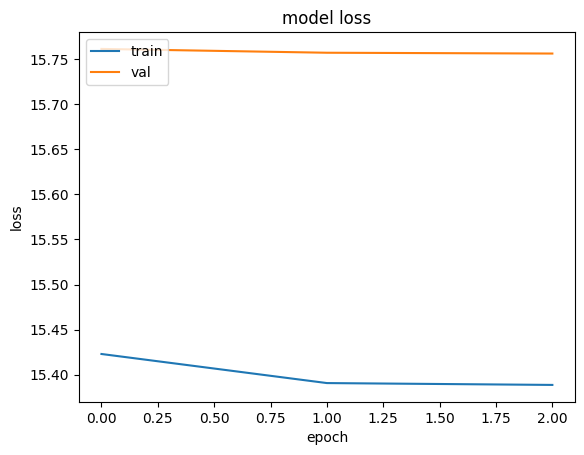


VAE encoded data is stored under -- /latent_space_data/vae/ folder!



Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  247935    
                                                                 
 decoder (Decoder)           multiple                  243401    
                                                                 
Total params: 491,336
Trainable params: 491,336
Non-trainable params: 0
_________________________________________________________________
predicting...


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
shape of predicted data:  (68, 1)


  2%|▏         | 1/50 [00:01<01:21,  1.66s/it]

1/1 [==============================] - 1s 1s/step


  4%|▍         | 2/50 [00:03<01:15,  1.56s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 3/50 [00:04<01:13,  1.56s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 4/50 [00:07<01:37,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 5/50 [00:10<01:47,  2.38s/it]

1/1 [==============================] - 1s 1s/step


 12%|█▏        | 6/50 [00:12<01:32,  2.09s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 7/50 [00:13<01:22,  1.92s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 8/50 [00:15<01:15,  1.80s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 9/50 [00:16<01:10,  1.72s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 10/50 [00:19<01:19,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 11/50 [00:21<01:16,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 12/50 [00:23<01:16,  2.01s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 13/50 [00:25<01:11,  1.92s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 14/50 [00:26<01:05,  1.81s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 15/50 [00:28<01:00,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 16/50 [00:29<00:56,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 17/50 [00:31<00:54,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 18/50 [00:32<00:51,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 19/50 [00:34<00:50,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 20/50 [00:37<01:00,  2.02s/it]

1/1 [==============================] - 1s 1s/step


<ipython-input-36-c0f5986ef987>:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, sharey=True)
 42%|████▏     | 21/50 [00:39<00:55,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 22/50 [00:40<00:50,  1.81s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▌     | 23/50 [00:42<00:46,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 24/50 [00:45<00:53,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 25/50 [00:46<00:47,  1.91s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 26/50 [00:48<00:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 27/50 [00:50<00:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 28/50 [00:52<00:43,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 29/50 [00:53<00:38,  1.82s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████    | 30/50 [00:55<00:34,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 31/50 [00:56<00:32,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 32/50 [00:58<00:29,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 33/50 [01:01<00:34,  2.02s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 34/50 [01:04<00:36,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 35/50 [01:07<00:36,  2.46s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 36/50 [01:08<00:30,  2.19s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 37/50 [01:10<00:25,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 38/50 [01:11<00:22,  1.85s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 39/50 [01:13<00:19,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 40/50 [01:14<00:16,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 41/50 [01:16<00:15,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 42/50 [01:19<00:16,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 43/50 [01:21<00:13,  1.90s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 44/50 [01:23<00:13,  2.18s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 45/50 [01:25<00:09,  1.97s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 46/50 [01:26<00:07,  1.84s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 47/50 [01:28<00:05,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 48/50 [01:31<00:04,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 49/50 [01:34<00:02,  2.32s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


done predicting


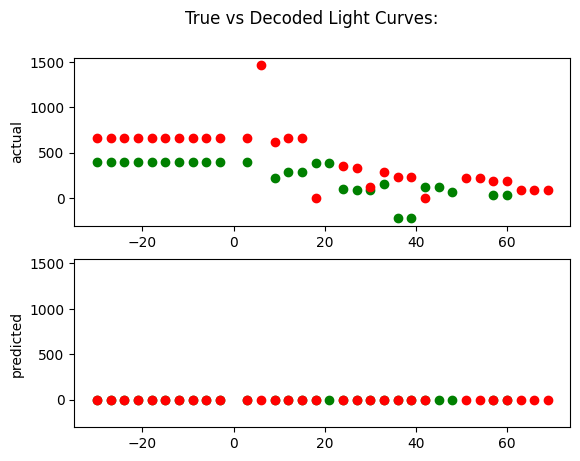

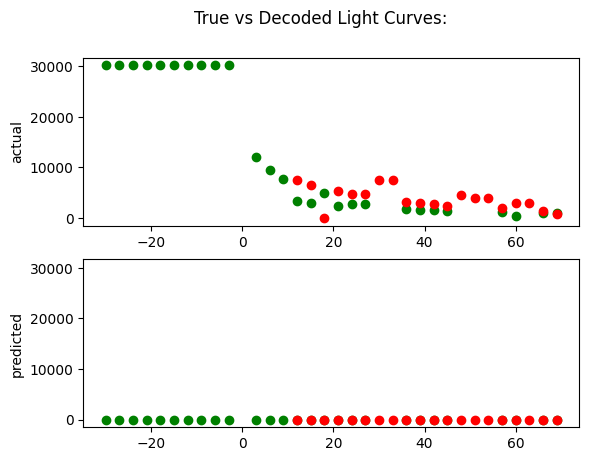

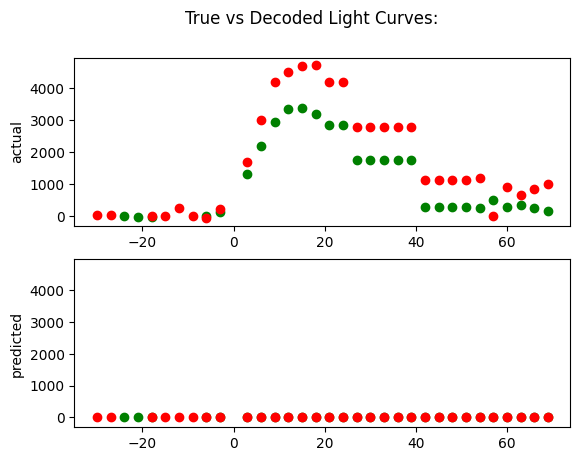

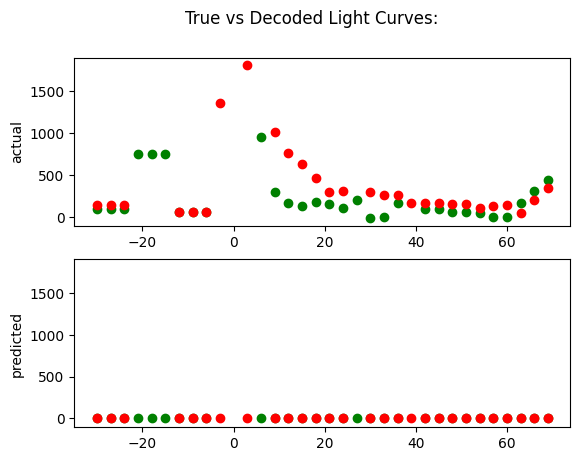

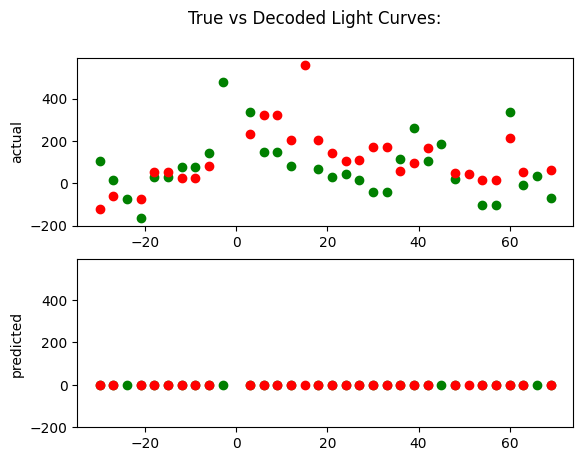

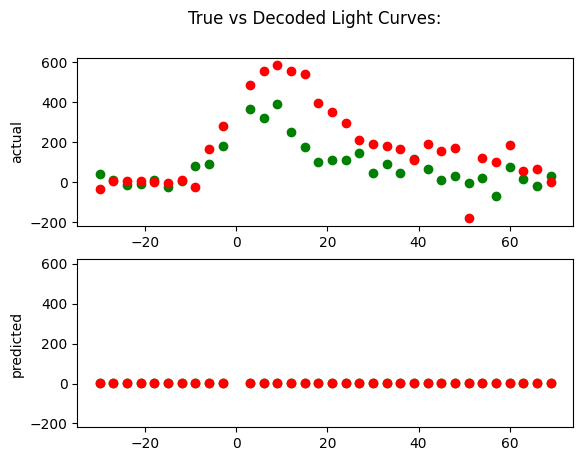

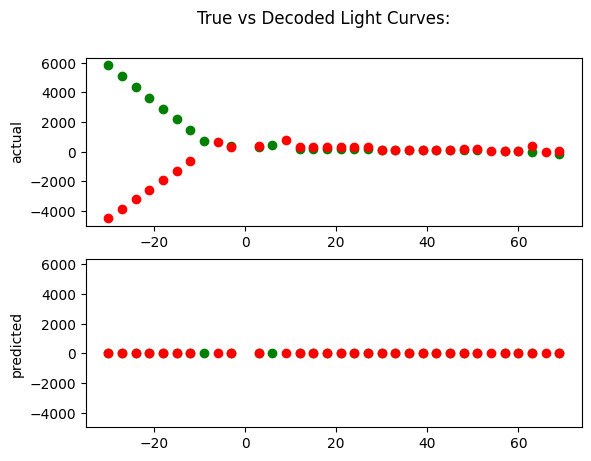

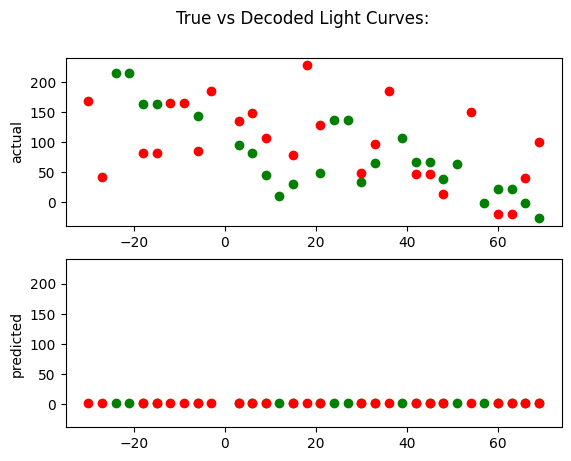

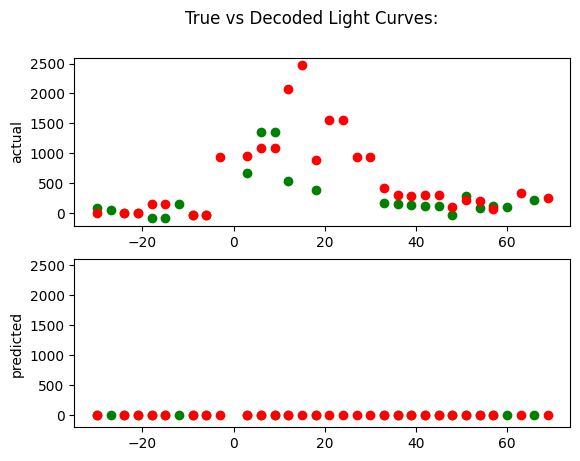

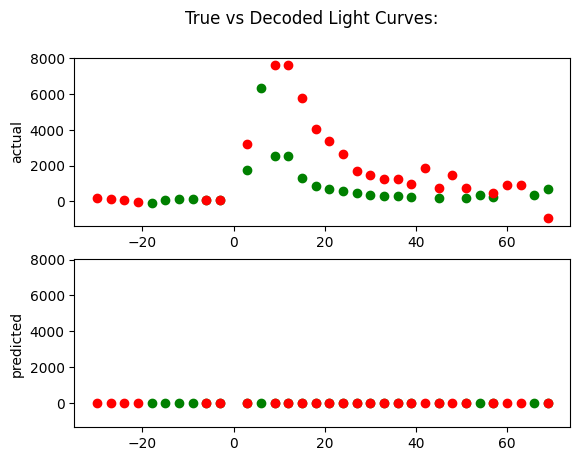

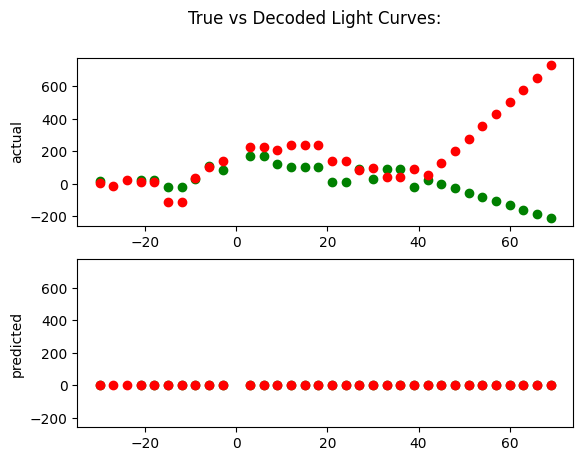

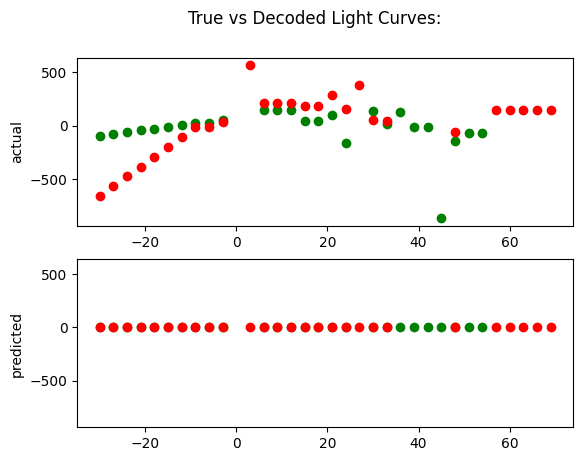

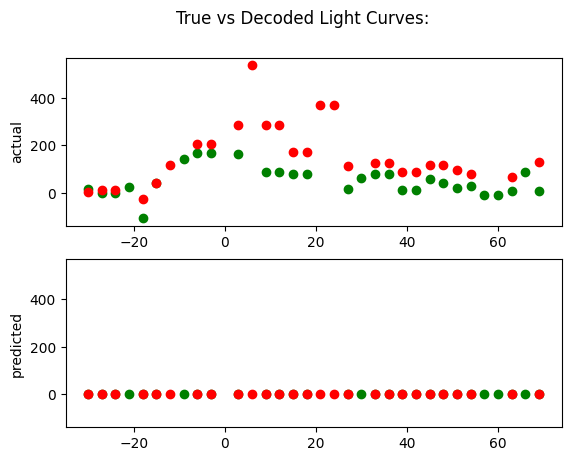

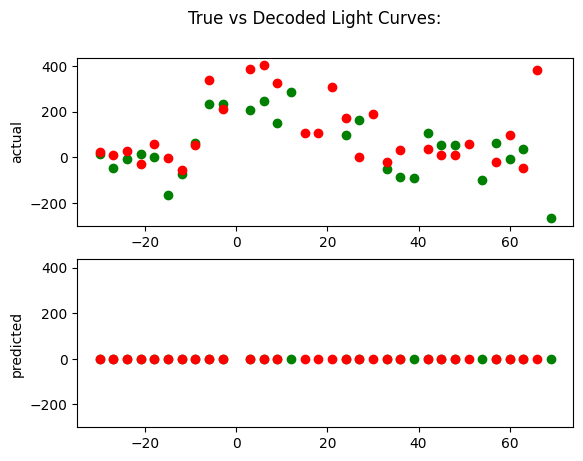

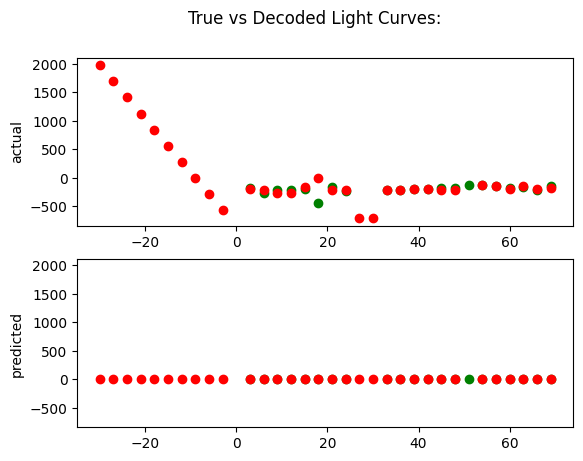

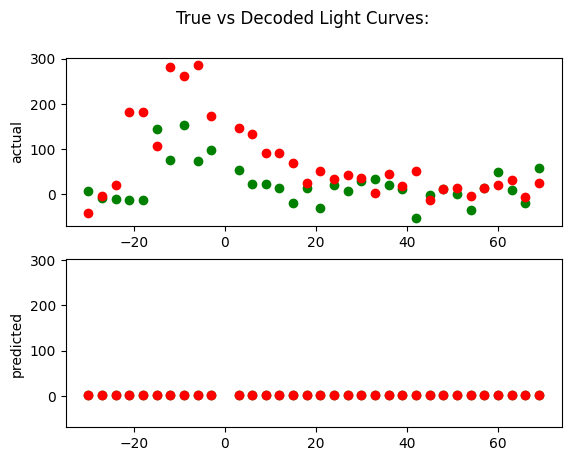

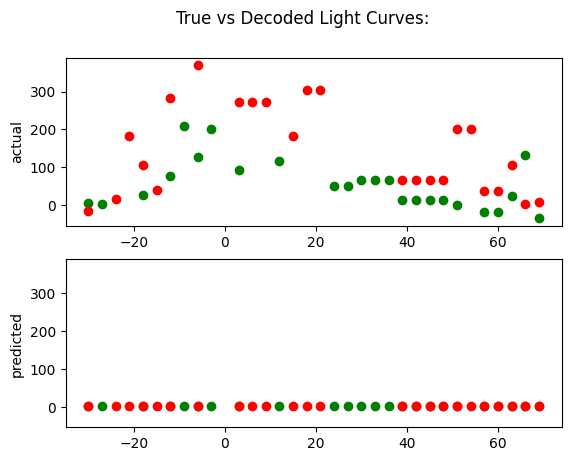

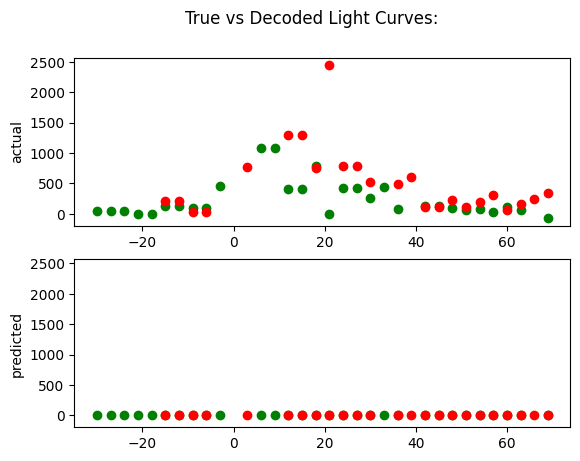

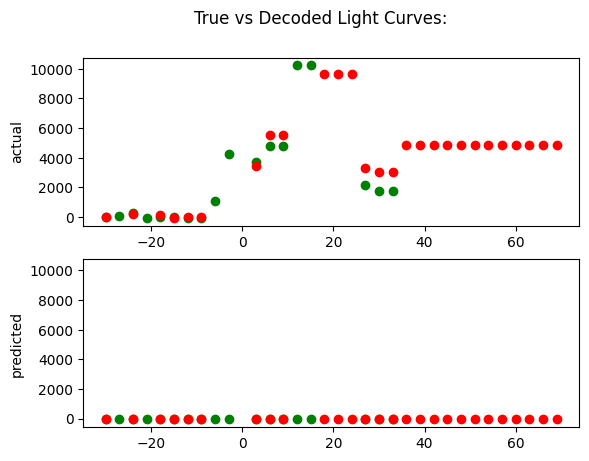

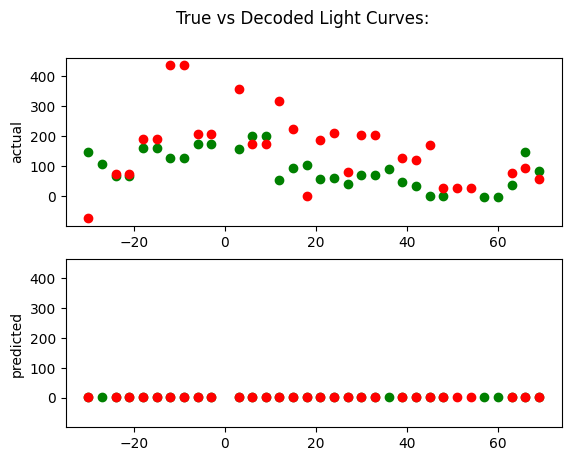

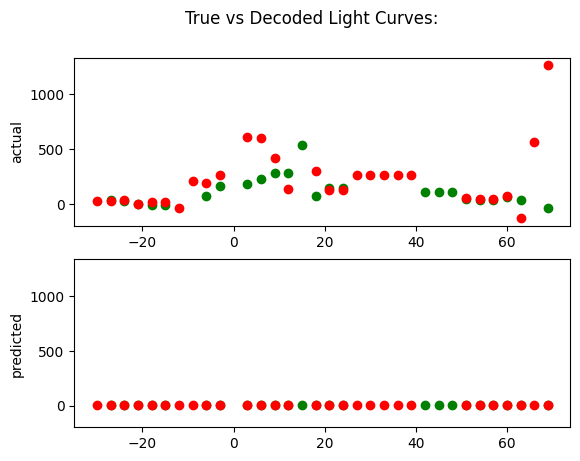

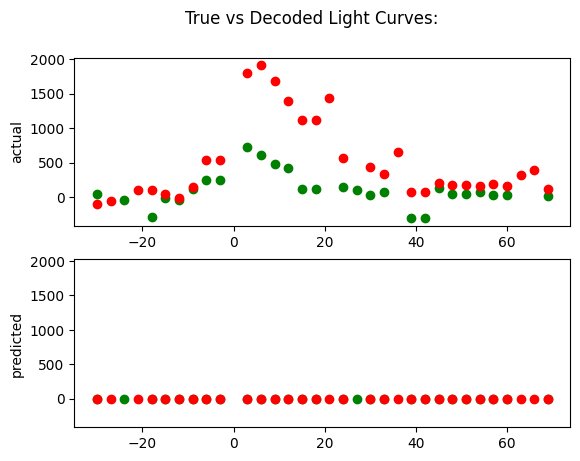

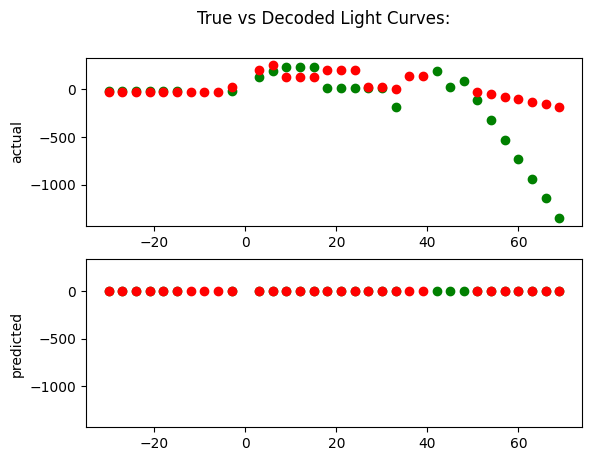

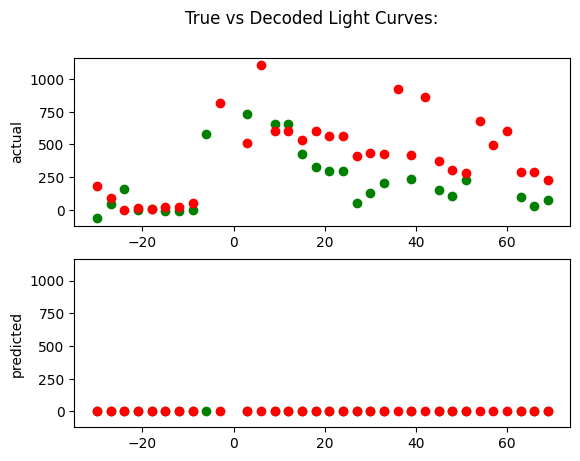

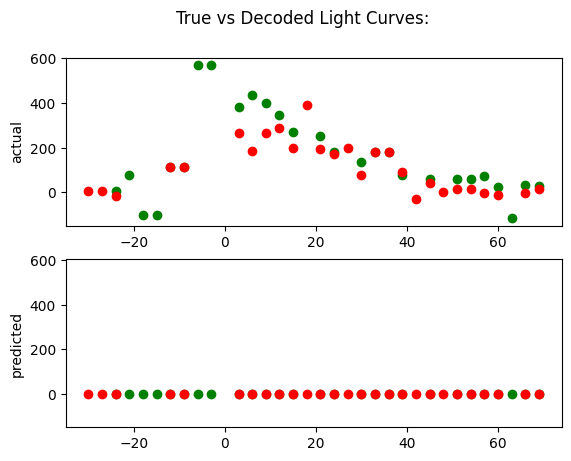

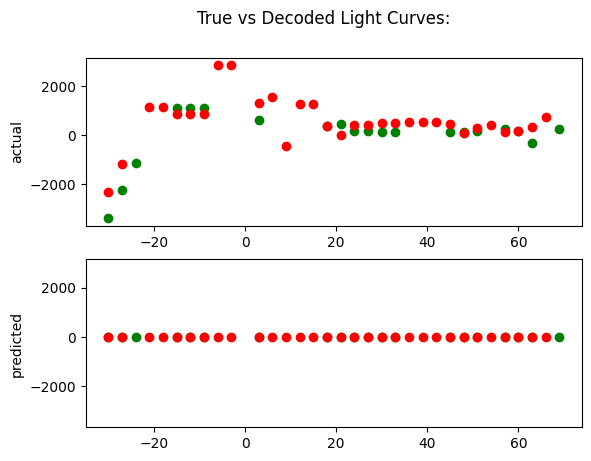

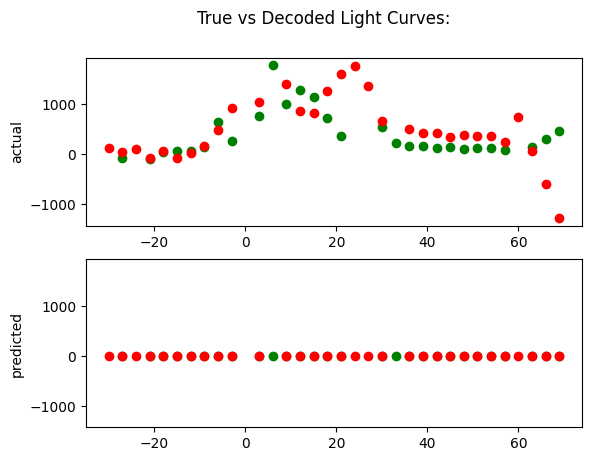

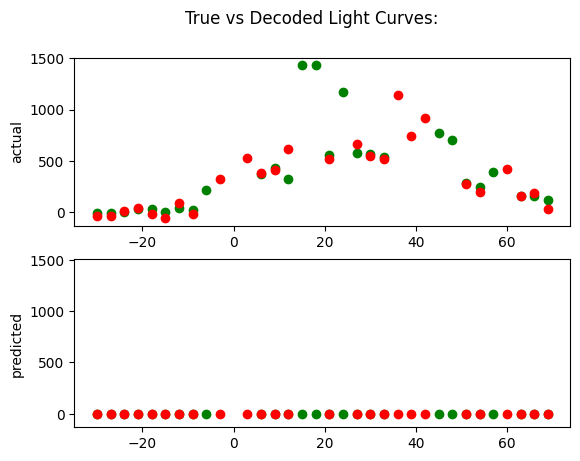

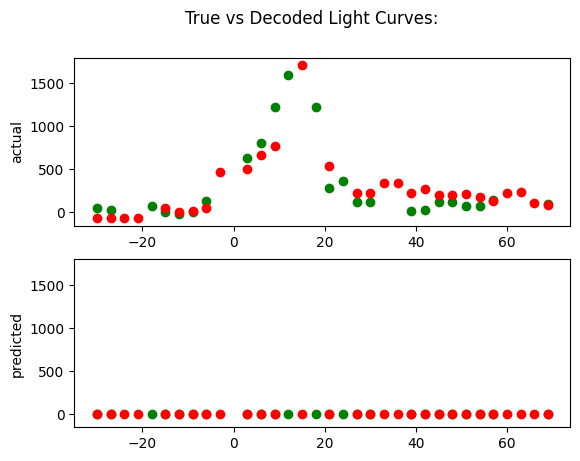

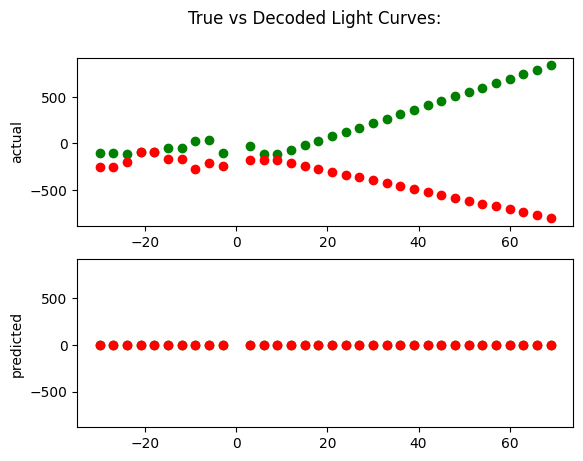

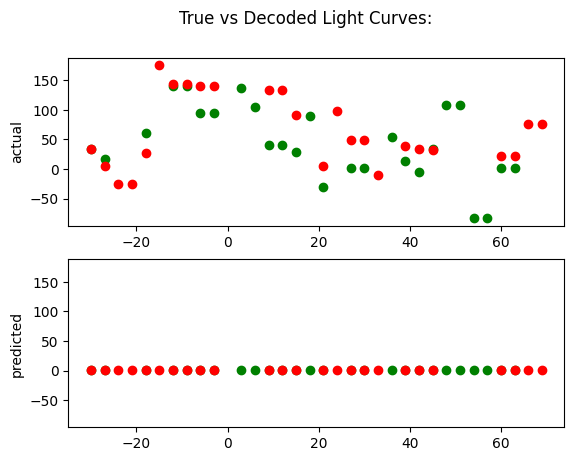

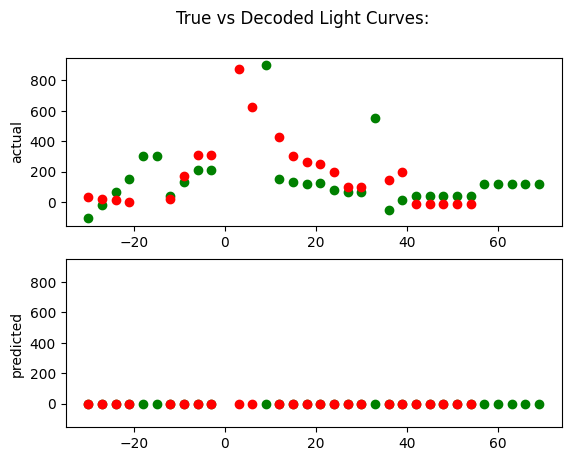

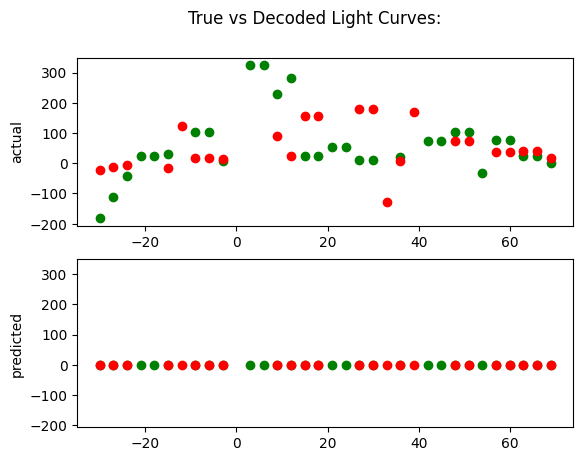

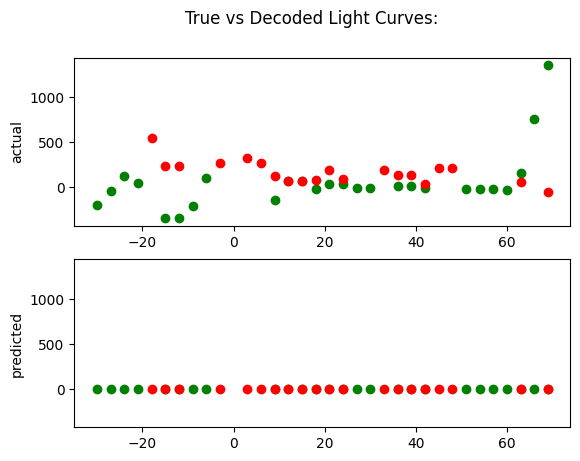

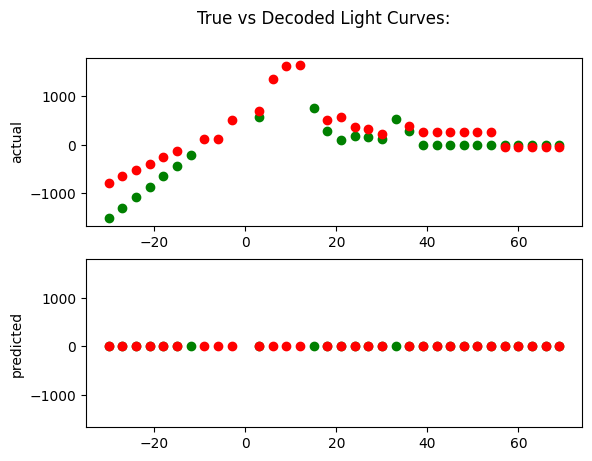

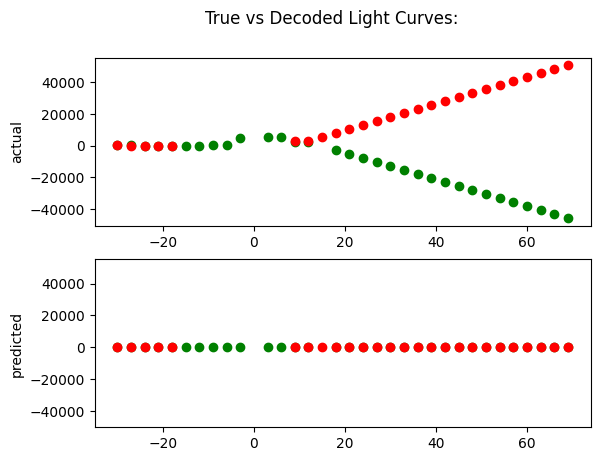

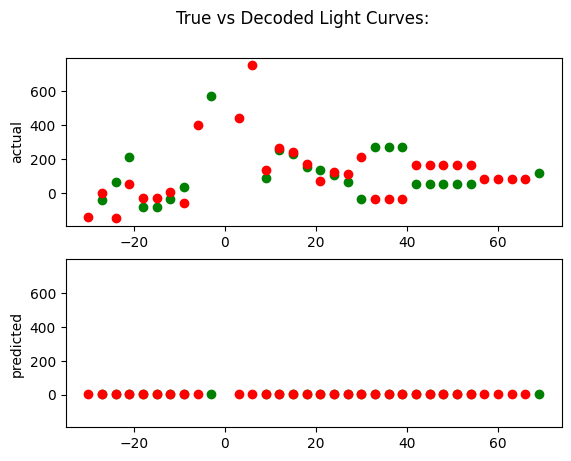

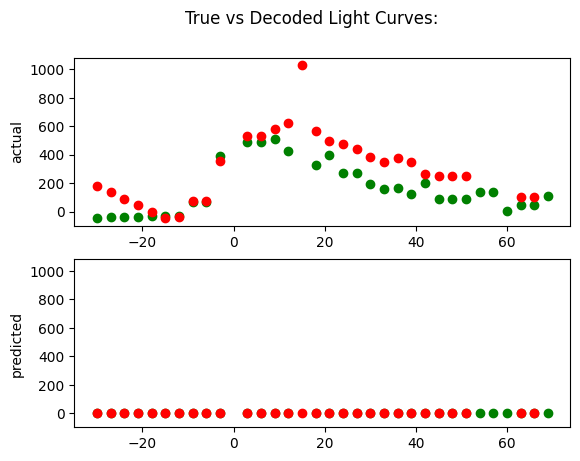

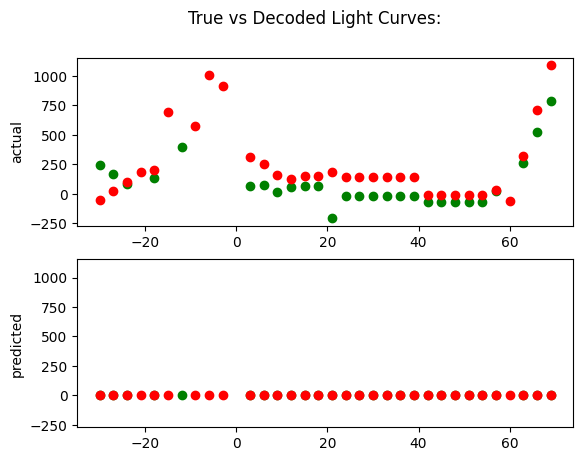

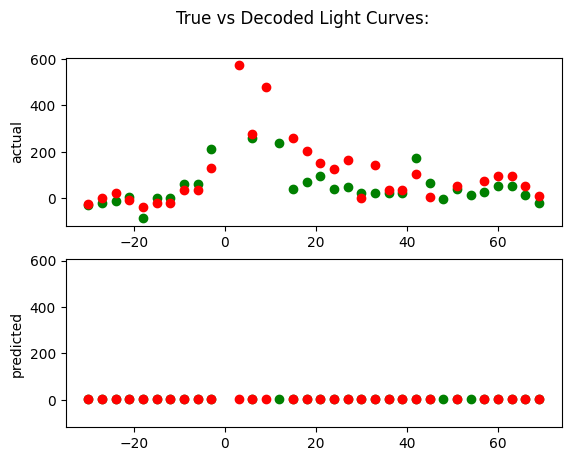

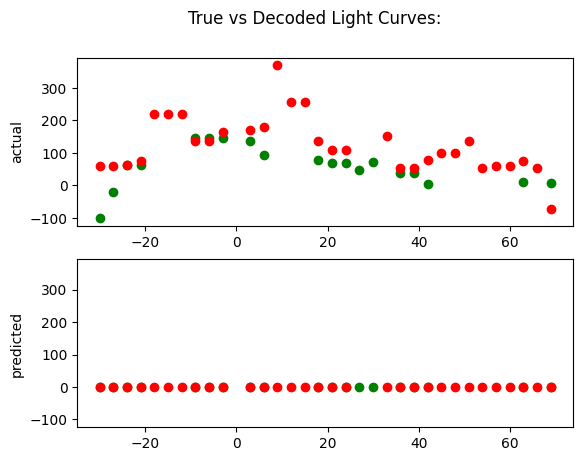

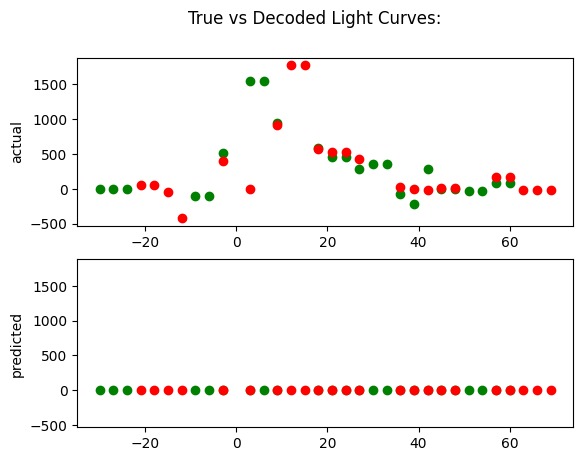

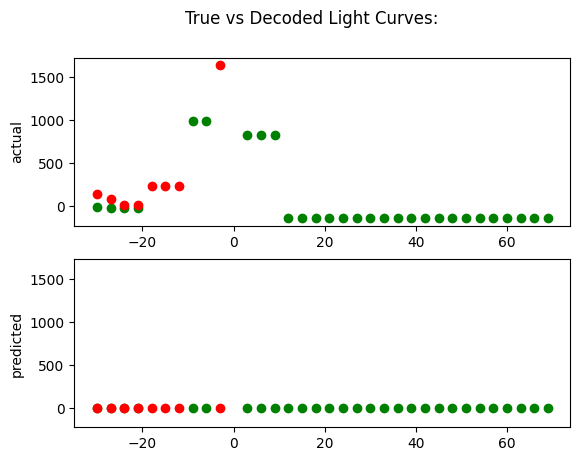

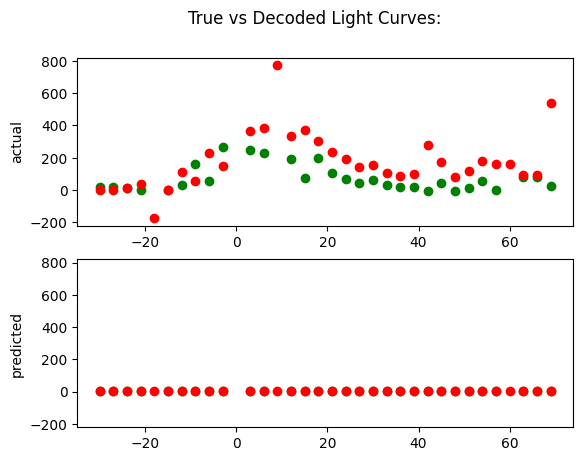

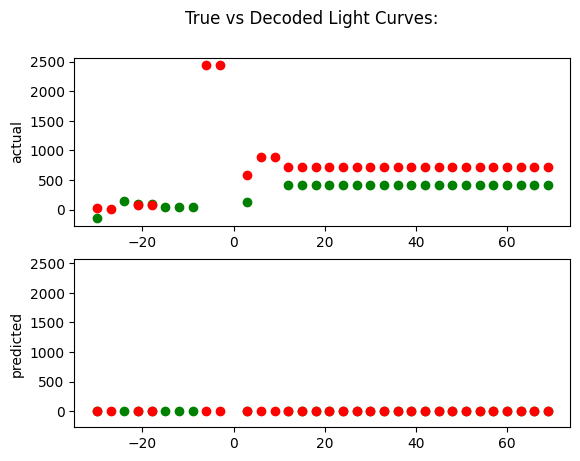

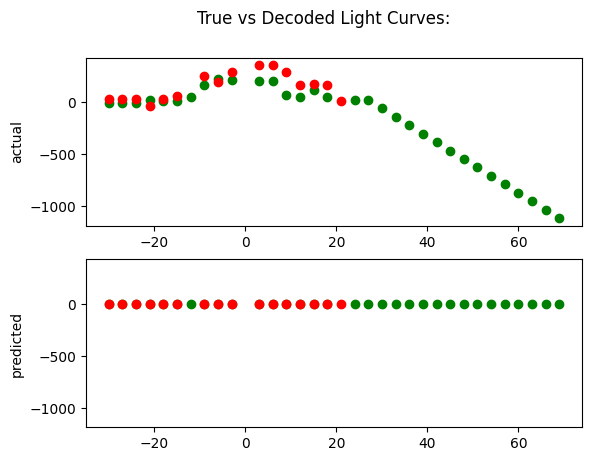

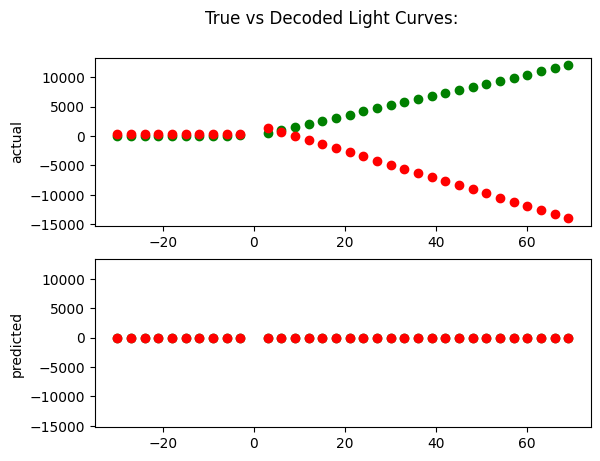

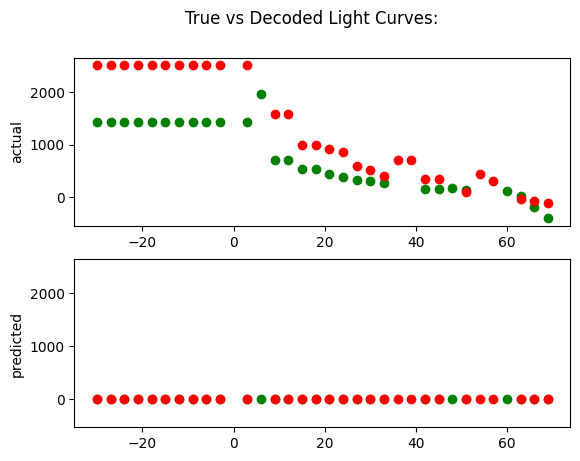

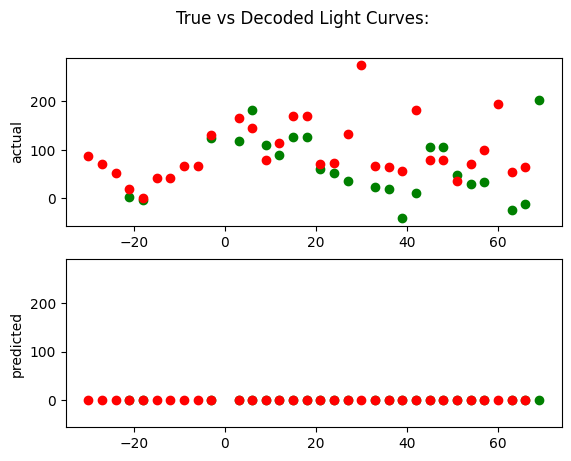

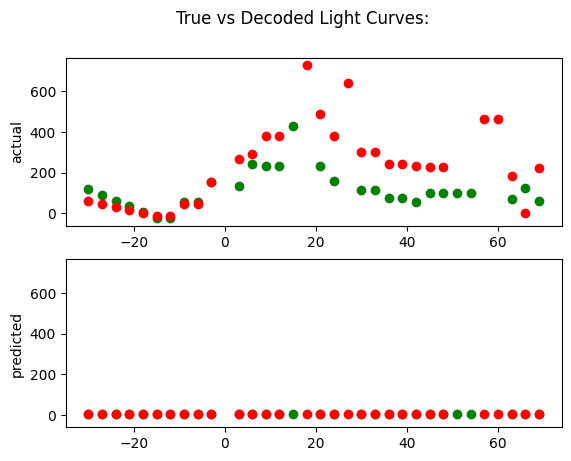

In [38]:
if __name__ == '__main__':

    #
    # Generate data for the VAE model
    #
    data = GenerateData(lc_type="transients", path=f"/content/gdrive/My Drive/processed_data/", 
                        passbands=["g", "r"], metadata=["redshift", "mwebv"])
    data.generate_data()
    #
    # Load the data
    #
    try:
        with open(f"/content/gdrive/My Drive/latent_space_data/vae/vae_data.pickle", 'rb') as file:
            data = pickle.load(file)
    except Exception as e:
        print(f"\nUnknownError: {e}\n")  

    try:
      #
      # Train VAE with training data set
      #
      vae = VAE(data["x_train"])
      #
      # Split the dataset in train & test
      #
      x_train, x_test, y_train, y_test, prep_inp, prep_out = vae.split_training_data()
      #
      # Declare path_to_store for the VAE model
      #
      model_path = "/content/gdrive/My Drive/latent_space_data/vae/"
      #
      # Declare the VAE model with parameters
      #
      optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
      vae.compile(optimizer=optimizer, loss=vae.reconstruction_loss)
      vae.epochs = 3
      #
      # Train the VAE model
      # 
      vae.train_model(x_train, x_test, y_train, y_test)
      #
      # Save the encoded data 
      #
      vae.save_latent_space(data)
      vae.save(model_path + "vae_model")
      #
      # Load saved model
      #
      rvae = VAE(data["x_train"])
      vae = keras.models.load_model(
            model_path + "vae_model",
            custom_objects={
              'VAE': rvae,
              'Encoder': Encoder,
              'Decoder': Decoder,
              'Sampling': Sampling,
              'reconstruction_loss': rvae.reconstruction_loss,
              'CustomMasking': CustomMasking})
      #
      # Call the saved model to evaluate the performance of the test data
      #
      vae.test_model(prep_inp, prep_out, amount=50)
    #
    #
    #
    except Exception as e:
      print(f"\nUnknownError: {e}\n") 